# Distribution of fitness effects model

Figure 3

In [1]:
import evolutionary_functions as ev

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.integrate as it
from scipy.stats import kde
import pandas as pd
from scipy.special import gamma
from IPython.display import clear_output
import scipy.optimize as opt
import os
import datetime

# plotting defaults
import matplotlib
matplotlib.rc_file_defaults()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Lato'


### Import data

In [2]:
# number of quantiles for plotting: choose 3 or 4
# must be 3 if using pre-calculated values for density
number_of_quantiles = 3

# import age distribution and quantile labels
biobank_bins_quantiles = pd.read_csv('inputs_participants/biobank_bins_quantiles.tsv', sep='\t').rename(
    columns={f'quantile_labels_{number_of_quantiles}': 'quantile_labels'})[
    ['Age.when.attended.assessment.centre_v0', 'age_count', 'quantile_labels']]
number_of_individuals = biobank_bins_quantiles.age_count.sum()

In [3]:
trimming_thresholds = {'DNMT3A R882H':0.03603267304887714,
                       'DNMT3A R882C':0.03641125564466615,
                       'DNMT3A Y735C': 0.02, #0.031021452650779963,
                       'DNMT3A P904L': 0.03050625833173621,
                       'DNMT3A R736H': 0.03875482257879603,
                       'DNMT3A R771*': 0.03427038103403027,
                       'DNMT3A R736C': 0.02691079729604606,
                       'DNMT3A R326C': 0.028204184173756756,
                       'DNMT3A R598*': 0.03076131339432306,
                       'DNMT3A R729W': 0.03783540677226178,
                       'GNB1 K57E': 0.14153654536164767,
                       'DNMT3A R320*': 0.028631527128345668,
                       'SRSF2 P95H': 0.04347979091423723,
                       'JAK2 V617F': 0.13520099097390018,
                       'SF3B1 K700E': 0.04598031864820239,
                       'SRSF2 P95R': 0.02953317476037705,
                       'SRSF2 P95L': 0.043065694094422076,
                       'DNMT3A R882S': 0.03679934975977073,
                       'IDH2 R140Q': 0.06330736020657143,
                       'SF3B1 K666N': 0.06919892423070759}

In [4]:
ukb_variants = pd.read_csv('inputs_variants/ukb_variants_trimmed_WIP.tsv', sep='\t')

# attach age quantile data
ukb_variants_quantiles = pd.merge(ukb_variants, biobank_bins_quantiles[['Age.when.attended.assessment.centre_v0', f'quantile_labels']], on='Age.when.attended.assessment.centre_v0', how='left')

# create useful dictionary of variant dataframes
ukb_variants_dict = {}
for varid in ukb_variants_quantiles.varID.unique():
    ukb_variants_dict[varid] = ukb_variants_quantiles[ukb_variants_quantiles['varID'] == varid].reset_index(drop=True)

### Results

Import optimised parameters

In [6]:
filename = 'results_files/hotspot_DFE_results_combined.tsv'
results_to_plot = pd.read_csv(filename, sep='\t').reset_index(drop=True)

Import results of density calculations. These take a long time to calculate, so are provided here -- the script for calculating them is provided at the end of the notebook.

In [7]:
overall_density_dict = np.load('results_files/DFE_overall_density.npy', allow_pickle=True).item()
quantile_density_dict = np.load('results_files/DFE_quantile_density.npy', allow_pickle=True).item()

### Figure 3

In [11]:
def cumulative_naive_rho(f, mu, s, age, N):
    return it.quad(ev.rho_of_f, f, 0.5, args=(mu, s, age, N))[0]

In [12]:
def cumulative_dfe_rho(f, mu, sbar, sigma, age, N):
    return it.quad(ev.dfe_rho_integrated, f, 0.5, args=(mu, sbar, sigma, age, N))[0]

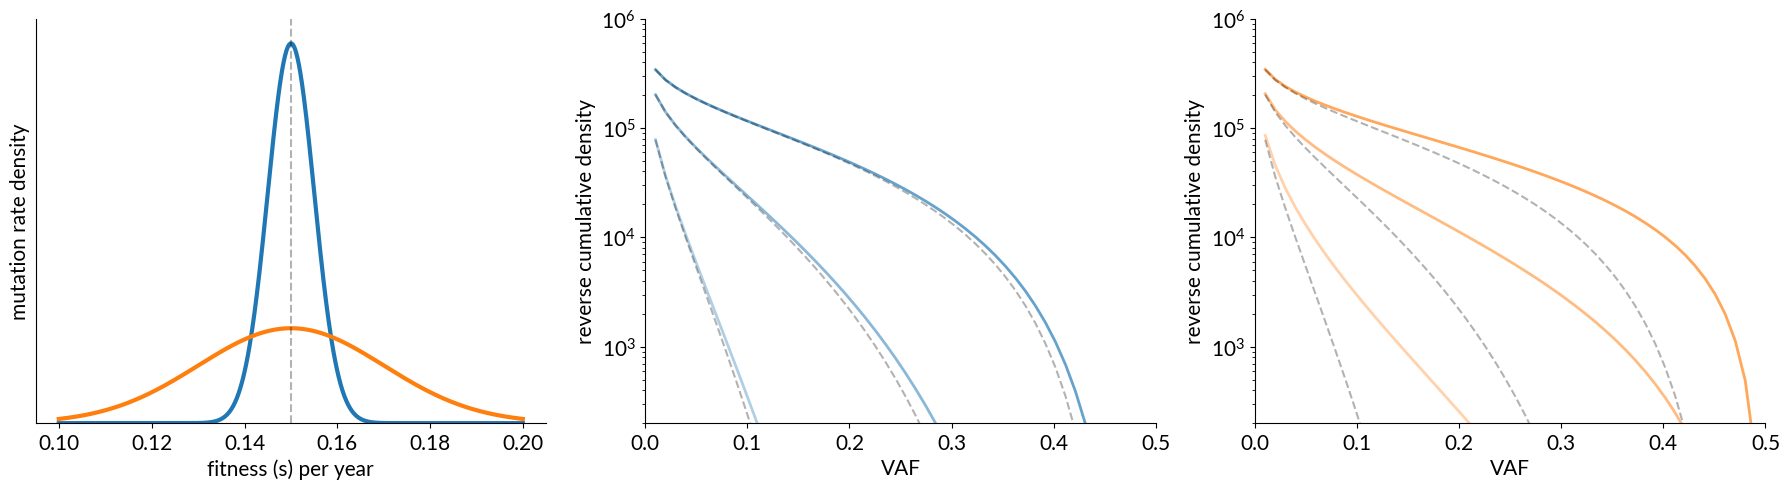

In [13]:
# Fig. 3: example Gaussian DFE density plots

fig, ax = plt.subplots(1, 3, figsize=[18, 5])

x_theory = np.logspace(-5, np.log10(0.499), 1000)
x_theory = np.linspace(0.01, 0.49, 50)
s_range = np.arange(0.10, 0.20, 0.0001)
N = 100000
#step_age = 40 # we don't actually use alpha

mu, sbar = [1e-7, 0.15]
sigma = 0.005
ax[0].plot(s_range, ev.gaussian_dfe_function(s_range, sbar, sigma), color='C0', lw=3)

for age in [45, 55, 65]:
    y_theory = []
    for x in x_theory:
        y_theory.append(cumulative_dfe_rho(x, mu, sbar, sigma, age, N))

    ax[1].plot(x_theory, np.array(y_theory)/mu, color='C0', alpha=age/60-0.4, lw=2)

#sigma = 0.01
#ax[0].plot(s_range, gaussian_dfe_function(s_range, sbar, sigma), color='C1')

#for age in [45, 55, 65]:
#    y_theory = []
#    for x in x_theory:
#        y_theory.append(heuristic_dfe_rho_integrated(x, mu, sbar, sigma, age, N))
#
#    ax[1].plot(x_theory, np.array(y_theory)*x_theory/mu, color='C1', alpha=age/60-0.4)
#
mu, sbar = [1e-7, 0.15]
sigma = 0.02
ax[0].plot(s_range, ev.gaussian_dfe_function(s_range, sbar, sigma), color='C1', lw=3)


for age in [45, 55, 65]:
    y_theory = []
    for x in x_theory:
        y_theory.append(cumulative_dfe_rho(x, mu, sbar, sigma, age, N))

    ax[2].plot(x_theory, np.array(y_theory)/mu, color='C1', alpha=age/60-0.4, lw=2)

ax[0].vlines(0.15, 0, 100, ls='dashed', color='k', alpha=0.3)

for age in [45, 55, 65]:
    y_theory = []
    for x in x_theory:
        y_theory.append(cumulative_naive_rho(x, mu, 0.15, age, N))

    ax[1].plot(x_theory, np.array(y_theory)/mu, color='k', ls='dashed', alpha=0.3) #*x_theory/mu
    ax[2].plot(x_theory, np.array(y_theory)/mu, color='k', ls='dashed', alpha=0.3) #*x_theory/mu


for i in [1, 2]:
    ax[i].set_yscale('log')
    #ax[i].set_xscale('log')
    ax[i].set_ylim(2e2, 1e6)
    ax[i].set_xlim(10e-3, 1)
    ax[i].set_xlim(0, 0.5)
    ax[i].set_ylabel('reverse cumulative density')
    ax[i].set_xlabel('VAF')
ax[0].set_yticks([])
ax[0].set_ylim(0, 85)
ax[0].set_xlabel('fitness (s) per year')
ax[0].set_ylabel('mutation rate density')
plt.tight_layout()

#plt.savefig('results_recall/recall_publication_plots/gaussian_DFE_demo_cumulative.pdf')
plt.show()

In [15]:
# calculate density for single-fitness (MLE) optimisation
single_fitness_LL_results = pd.read_csv('../results_recall/MLE_naive_optimiser/simple_MLE_optimisation.tsv', sep='\t')
varid = 'DNMT3A P904L'
N = 100000
naive_row = single_fitness_LL_results[single_fitness_LL_results.varID == varid]
mu_delta, s_delta = [naive_row.mu.squeeze(), naive_row.s.squeeze()]
variant_quantiles = ukb_variants_dict[varid]

def delta_predictions_calc(mu, s, N, variant_quantiles):
    D = int(variant_quantiles.depth.mean())
    number_of_individuals = biobank_bins_quantiles.age_count.sum()

    sampled_quantile_density = {}
    cumul_quantile_density = {}
    sampled_overall_density = np.zeros(D + 1)

    for qt in range(number_of_quantiles):
        quantile_age_bins = biobank_bins_quantiles[biobank_bins_quantiles.quantile_labels == qt]
        n_in_quantile = quantile_age_bins.age_count.sum()

        # calculate sampled density
        sampled_quantile_density[qt] = np.zeros(D + 1)
        for row in quantile_age_bins.index:
            age = quantile_age_bins['Age.when.attended.assessment.centre_v0'][row]
            age_count = quantile_age_bins['age_count'][row]

            for r in range(D + 1):
                increment = ev.rho_with_sampling(r, D, mu, s, age, N) * age_count
                sampled_quantile_density[qt][r] += increment / n_in_quantile
                sampled_overall_density[r] += increment / number_of_individuals

                clear_output()
                print(age, age_count)
                #print(r, '/', D)

        cumul_quantile_density[qt] = np.cumsum(sampled_quantile_density[qt][::-1])[::-1]

    cumul_overall_density = np.cumsum(sampled_overall_density[::-1])[::-1]

    return cumul_overall_density, cumul_quantile_density


delta_overall_density, delta_quantile_density = delta_predictions_calc(mu_delta, s_delta, N, variant_quantiles)

73 1


Restate plotting functions, but removing need to plot points (density line only)

In [18]:
def overall_density_plot_line_only(ax, variant_quantiles, mu, cumul_overall_density, number_of_individuals, colour,
                                   errorbars=True):
    D = int(variant_quantiles.depth.mean())
    x = np.arange(D + 1) / D
    n_variants = len(variant_quantiles)
    variants_ordered = variant_quantiles.sort_values('VAF', ascending=False)
    y = (np.arange(n_variants) + 1) / (number_of_individuals * mu)
    ax.plot(x, cumul_overall_density / mu, color=colour, ls='dashed', alpha=0.5)
    #ax.scatter(variants_ordered.VAF, y, s=10, alpha=0.5, color=colour)
    #if errorbars:
    #    yerr = np.sqrt(np.arange(n_variants) + 1) / (number_of_individuals * mu)
    #    ax.errorbar(variants_ordered.VAF, y, yerr, color=colour, ls='none', elinewidth=0.5)
    return 0


def quantile_density_plot_line_only(ax, variant_quantiles, mu, cumul_quantile_density, number_of_quantiles,
                                    quantile_colour_list, biobank_bins_quantiles, errorbars=False):
    for qt in range(number_of_quantiles):
        D = int(variant_quantiles.depth.mean())
        x = np.arange(D + 1) / D
        n_in_quantile = sum(biobank_bins_quantiles[biobank_bins_quantiles.quantile_labels == qt].age_count)
        variants = variant_quantiles[variant_quantiles.quantile_labels == qt]
        n_variants = len(variants)
        variants_ordered = variants.sort_values('VAF', ascending=False)
        y = (np.arange(n_variants) + 1) / (n_in_quantile * mu)
        ax.plot(x, cumul_quantile_density[qt] / mu, color=quantile_colour_list[qt], ls='dashed', alpha=0.4)
        #ax.scatter(variants_ordered.VAF, y, s=10, alpha=0.7, color=quantile_colour_list[qt])
        #if errorbars:
        #    yerr = np.sqrt(np.arange(n_variants) + 1) / (n_in_quantile * mu)
        #    ax.errorbar(variants_ordered.VAF, y, yerr, color=quantile_colour_list[qt], ls='none', elinewidth=0.5)
    return 0

Figure 3: comparison of DFE results, DNMT3A P904L as an example

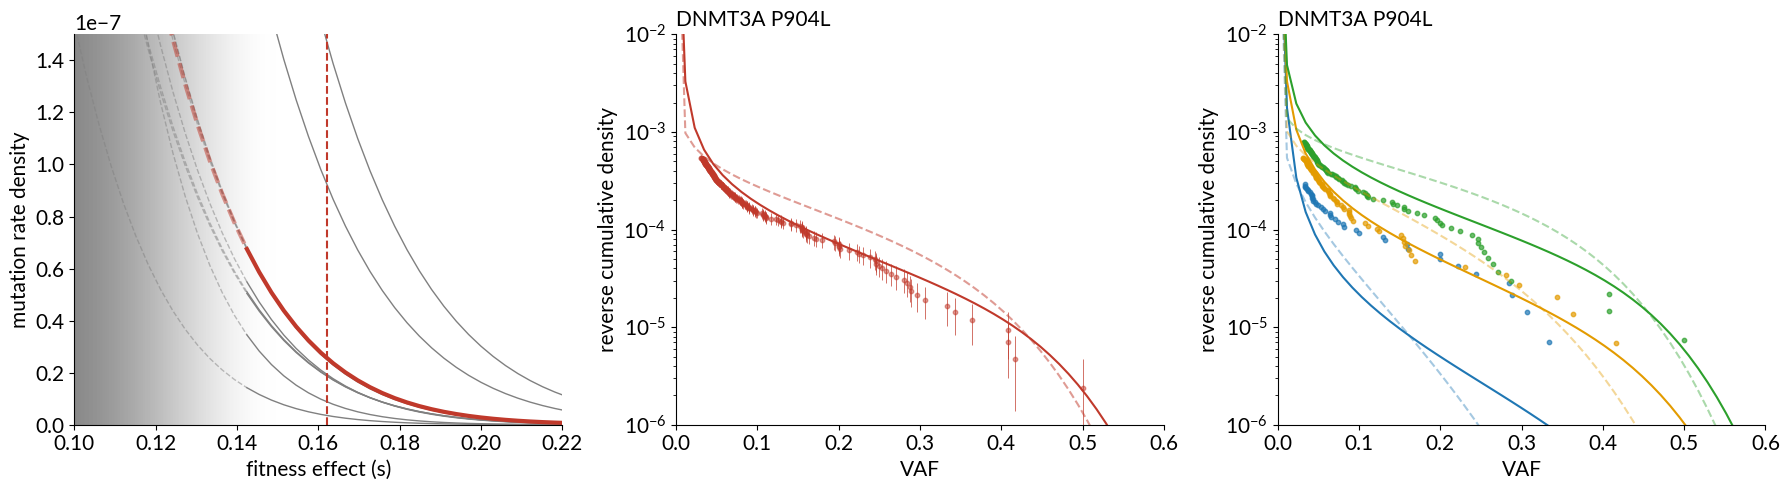

In [22]:

fig, ax = plt.subplots(1, 3, figsize=[18, 5]) # [8, 7] for 2x2 version
ax = ax.ravel()
col = 0
variant_colour_list = ['#C0392B', 'darkorange', 'darkblue']
quantile_alpha_list_points = [0.2, 0.4, 1]
quantile_alpha_list_lines = [0.5, 0.7, 1]
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']

varid = 'DNMT3A P904L'
variant_quantiles = ukb_variants_dict[varid]
opt_row = results_to_plot[results_to_plot.varID == varid]
mu, sbar, sigma= [opt_row.mu.squeeze(), opt_row.sbar.squeeze(), opt_row.sigma.squeeze()]
ev.overall_density_plot(ax[1], variant_quantiles, 1, overall_density_dict[varid], number_of_individuals, colour='#C0392B')
ev.quantile_density_plot(ax[2], variant_quantiles, 1, quantile_density_dict[varid], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
#ax[i+1].set_title(varid+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
#ax[i+1].text(0.4, 1e5, fr'$\mu = {mu:.2g}$'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%'+'\n'+fr'$\sigma = {sigma:.2g}$')

#plot original function

overall_density_plot_line_only(ax[1], variant_quantiles, 1, delta_overall_density, number_of_individuals, colour='#C0392B') #mu_delta - normalise by 1, not mu, so that the two graphs are comparable
quantile_density_plot_line_only(ax[2], variant_quantiles, 1, delta_quantile_density, number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)

for i in range(1, 3):
    ax[i].set_title(varid, fontsize=15, loc='left')
    ax[i].set_xlabel('VAF')
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-6, 1e-2)
    ax[i].set_xlim(0, 0.6)
    ax[i].set_ylabel('reverse cumulative density')

#plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences[varid], colour='k', logscale=False)
x = np.linspace(0, 0.3, 100)
pdf = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - sbar)/sigma)**2)*mu

# Plot the Gaussian PDF
ax[0].plot(x[:48], pdf[:48], color='#C0392B', lw=3, ls='dashed', alpha=0.5) # DNMT3A colour
ax[0].plot(x[47:], pdf[47:], color='#C0392B', lw=3)
ax[0].vlines(s_delta, 0, 2e-7, ls='dashed', color='#C0392B')
ax[0].set_xlabel("fitness effect (s)")
#ax[0].grid(True)
ax[0].set_ylabel('mutation rate density')
ax[0].set_ylim(0, 1.5e-7)
ax[0].set_xlim(0.10, 0.22)

# plot the remaining variants:
for varid in results_to_plot.varID:
    if varid.split(' ')[0] == 'DNMT3A':
        opt_row = results_to_plot[results_to_plot.varID == varid]
        mu, sbar, sigma= [opt_row.mu.squeeze(), opt_row.sbar.squeeze(), opt_row.sigma.squeeze()]
        pdf = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - sbar)/sigma)**2)*mu
        ax[0].plot(x[:48], pdf[:48], color='grey', lw=1, ls='dashed', alpha=0.5, zorder=-1)
        ax[0].plot(x[47:], pdf[47:], color='grey', lw=1, zorder=-1)

from matplotlib.colors import LinearSegmentedColormap
#ax[0].axvspan(0, x[47], color='lightgrey', zorder=-2, alpha=0.3)
# Define the range of the gradient on the x-axis
x_start, x_end = 0.0875, 0.15
# Create a gradient colormap (fully opaque to fully transparent)
cmap = LinearSegmentedColormap.from_list("gradient", [(0, "grey"), (1, (1, 1, 1, 0))])
# Create the gradient
x = np.linspace(0, 1, 100)
gradient = np.vstack((x**2, x**2))
# Overlay the gradient using imshow
extent = [x_start, x_end, ax[0].get_ylim()[0], ax[0].get_ylim()[1]]
ax[0].imshow(gradient, aspect='auto', cmap=cmap, extent=extent, origin='lower', zorder=-5)
ax[0].axvspan(0, 0.0875, color='gainsboro', zorder=-5)

plt.tight_layout()
#plt.savefig('results/publication_plots/naive_4_variants.png')
#plt.savefig('results_recall/recall_publication_plots/DFE_effect_demonstration.pdf')
plt.show()

#Ages 37 to 52, 141611 individuals
#Ages 53 to 61, 146440 individuals
#Ages 62 to 73, 136038 individuals

### Supplementary figure 18

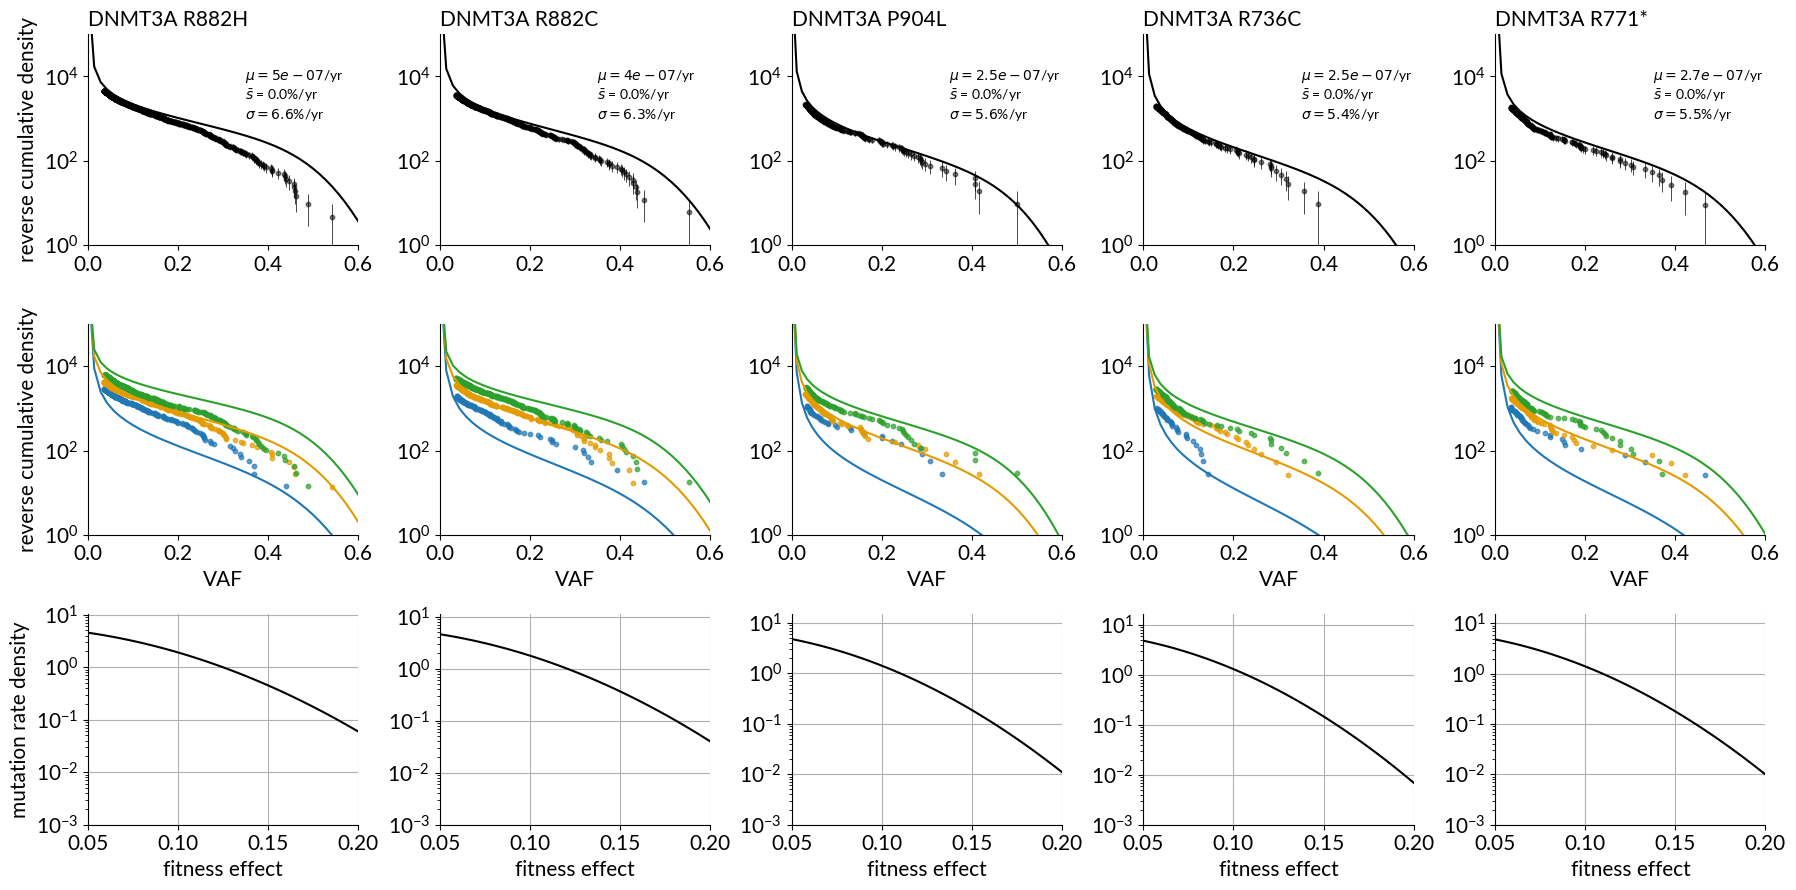

In [9]:
fig, ax = plt.subplots(3, 5, figsize=[18, 9])
col = 0
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']
index_range = np.arange(0, 5)
bins_age = np.arange(40, 70, 5)

for i, varid in enumerate(results_to_plot.varID):
    if i not in index_range:
        continue

    variant_quantiles = ukb_variants_dict[varid]
    opt_row = results_to_plot[results_to_plot.varID == varid]
    mu, sbar, sigma= [opt_row.mu.squeeze(), opt_row.sbar.squeeze(), opt_row.sigma.squeeze()]

    ev.overall_density_plot(ax[0, col], variant_quantiles, mu, overall_density_dict[varid], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu, quantile_density_dict[varid], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
    ax[0, col].set_title(varid, loc='left', fontsize=15) #+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
    ax[1, col].set_xlabel('VAF')
    ax[0, col].text(0.35, 1e3, fr'$\mu = {mu:.2g}$/yr'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%/yr'+'\n'+fr'$\sigma = {sigma*100:.2g}$%/yr')

    for row in range(2):
        ax[row, col].set_yscale('log')
        ax[row, col].set_ylim(1e0, 1e5)
        ax[row, col].set_xlim(0, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    #plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences[varid], colour='k', logscale=False)
    x = np.linspace(0, 0.3, 100)
    pdf = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - sbar)/sigma)**2)

    # Plot the Gaussian PDF
    ax[2, col].plot(x, pdf, color='k')
    ax[2, col].set_xlabel("fitness effect")
    ax[2, col].grid(True)
    ax[2, col].set_xlim(0.05, 0.20)
    ax[2, col].set_yscale("log")
    ax[2, col].set_ylim(1e-3)
    col += 1
ax[2, 0].set_ylabel('mutation rate density')
plt.tight_layout()
plt.show()

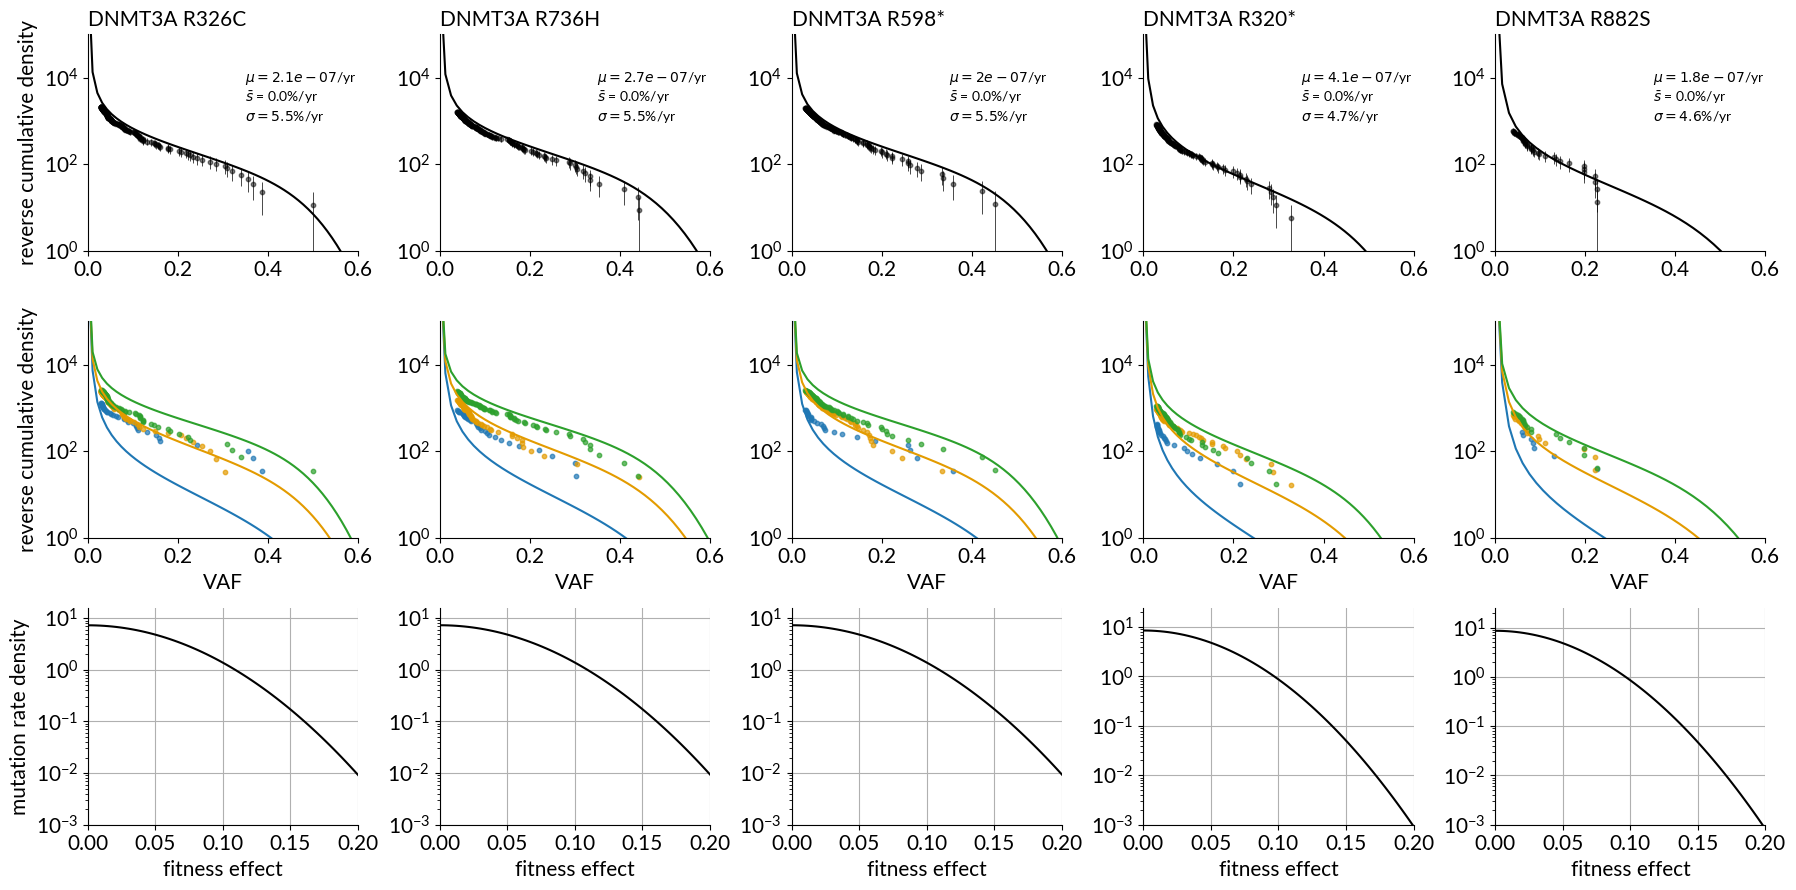

In [10]:
fig, ax = plt.subplots(3, 5, figsize=[18, 9])
col = 0
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3']
index_range = np.arange(5, 10)
bins_age = np.arange(40, 70, 5)

for i, varid in enumerate(results_to_plot.varID):
    if i not in index_range:
        continue

    variant_quantiles = ukb_variants_dict[varid]
    opt_row = results_to_plot[results_to_plot.varID == varid]
    mu, sbar, sigma= [opt_row.mu.squeeze(), opt_row.sbar.squeeze(), opt_row.sigma.squeeze()]

    ev.overall_density_plot(ax[0, col], variant_quantiles, mu, overall_density_dict[varid], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu, quantile_density_dict[varid], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles)
    ax[0, col].set_title(varid, loc='left', fontsize=15) #+'\n'+f'n = {len(variant_quantiles)}, D = {int(variant_quantiles.depth.mean())}', fontsize=15)
    ax[1, col].set_xlabel('VAF')
    ax[0, col].text(0.35, 1e3, fr'$\mu = {mu:.2g}$/yr'+'\n' + r'$\bar{s}$ = '+ f'{np.round(sbar*100, 1)}%/yr'+'\n'+fr'$\sigma = {sigma*100:.2g}$%/yr')

    for row in range(2):
        ax[row, col].set_yscale('log')
        ax[row, col].set_ylim(1e0, 1e5)
        ax[row, col].set_xlim(0, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    #plot_prevalence(ax[2, col], variant_quantiles, biobank_healthy_pheno, bins_age, prevalences[varid], colour='k', logscale=False)
    x = np.linspace(0, 0.3, 100)
    pdf = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - sbar)/sigma)**2)

    # Plot the Gaussian PDF
    ax[2, col].plot(x, pdf, color='k')
    ax[2, col].set_xlabel("fitness effect")
    ax[2, col].grid(True)
    ax[2, col].set_xlim(0, 0.20)
    ax[2, col].set_yscale("log")
    ax[2, col].set_ylim(1e-3)
    col += 1
ax[2, 0].set_ylabel('mutation rate density')
plt.tight_layout()
plt.show()

### Supplementary Figure 11

In [17]:
old_DFE_LL_results = pd.read_csv('../results_recall/DFE_optimiser/DFE_optimisation.tsv', sep='\t')
opt_results = pd.read_csv('../results_recall/DFE_optimiser/DFE_only_optimisation_redone_with_integration_correction_sigma0_0.001.tsv', sep='\t')

In [24]:
# results from two examples of model fitting (limited and unlimited s_bar)
fig_s11_results = pd.read_csv('results_files/DFE_Fig_S11_R771.csv')

In [29]:
varid = 'DNMT3A R771*'
old_opt_row = fig_s11_results.loc[0]
new_opt_row = fig_s11_results.loc[1]

mu_new, sbar_new, sigma_new = [new_opt_row.mu.squeeze(), new_opt_row.sbar.squeeze(), new_opt_row.sigma.squeeze()]
mu_old, sbar_old, sigma_old = [old_opt_row.mu.squeeze(), old_opt_row.sbar.squeeze(), old_opt_row.sigma.squeeze()]

In [20]:
# calculate densities - takes 30+ mins
old_density, old_quantile_density = ev.dfe_only_predictions_calc(mu_old, sbar_old, sigma_old, N, variant_quantiles, biobank_bins_quantiles, number_of_quantiles)
new_density, new_quantile_density = ev.dfe_only_predictions_calc(mu_new, sbar_new, sigma_new, N, variant_quantiles, biobank_bins_quantiles, number_of_quantiles)

73 1
74 / 74


In [21]:
def quantile_density_plot_shading(ax, variant_quantiles, mu, cumul_quantile_density, number_of_quantiles, colour,
                                 quantile_alpha_list_lines, quantile_alpha_list_points, biobank_bins_quantiles, errorbars=False):
    for qt in range(number_of_quantiles):
        D = int(variant_quantiles.depth.mean())
        x = np.arange(D + 1) / D
        n_in_quantile = sum(biobank_bins_quantiles[biobank_bins_quantiles.quantile_labels == qt].age_count)
        variants = variant_quantiles[variant_quantiles.quantile_labels == qt]
        n_variants = len(variants)
        variants_ordered = variants.sort_values('VAF', ascending=False)
        y = (np.arange(n_variants) + 1) / (n_in_quantile * mu)
        ax.plot(x, cumul_quantile_density[qt] / mu, color=colour, alpha=quantile_alpha_list_lines[qt])
        ax.scatter(variants_ordered.VAF, y, s=10, alpha=quantile_alpha_list_points[qt], color=colour)
        if errorbars:
            yerr = np.sqrt(np.arange(n_variants) + 1) / (n_in_quantile * mu)
            ax.errorbar(variants_ordered.VAF, y, yerr, color=quantile_colour_list[qt], ls='none', elinewidth=0.5)
    return 0

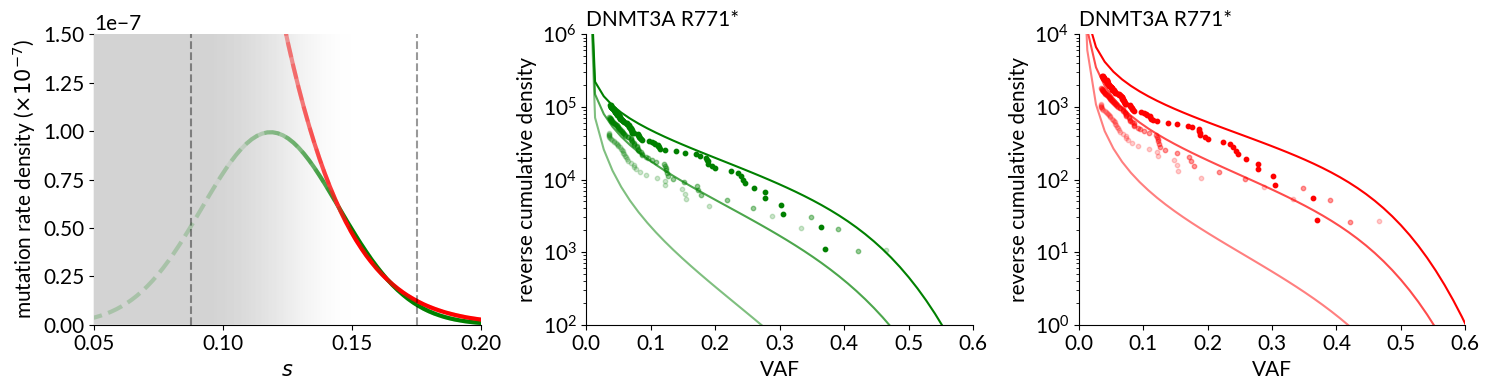

In [23]:
from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
quantile_alpha_list_points = [0.2, 0.4, 1]
quantile_alpha_list_lines = [0.5, 0.7, 1]


x = np.linspace(0, 0.2, 100)
old_pdf = (1/(sigma_old * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - sbar_old)/sigma_old)**2)*mu_old
new_pdf = (1/(sigma_new * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - sbar_new)/sigma_new)**2)*mu_new
# Plot the Gaussian PDF
ax[0].plot(x, old_pdf, color='green', lw=3, alpha=1)
ax[0].plot(x, old_pdf, color='green', lw=3, alpha=0.2, zorder=6, ls='dashed')
ax[0].plot(x, new_pdf, color='red', lw=3, alpha=1)
ax[0].plot(x, new_pdf, color='red', lw=3, alpha=0.2, zorder=6, ls='dashed')
ax[0].set_ylim(0, 1.5e-7)

# Define the range of the gradient on the x-axis
x_start, x_end = 0.0875, 0.15
# Create a gradient colormap (fully opaque to fully transparent)
cmap = LinearSegmentedColormap.from_list("gradient", [(0, "lightgrey"), (1, (1, 1, 1, 0))])
# Create the gradient
x = np.linspace(0, 1, 100)
gradient = np.vstack((x**2, x**2)) # power of 2 gives a better looking gradient
# Overlay the gradient using imshow
extent = [x_start, x_end, ax[0].get_ylim()[0], ax[0].get_ylim()[1]]
ax[0].imshow(gradient, aspect='auto', cmap=cmap, extent=extent, origin='lower', zorder=5)
ax[0].axvspan(0, 0.0875, color='lightgrey', zorder=5)
ax[0].vlines([0.0875, 0.175], 0, 1.5e-7, ls='dashed', color='k', alpha=0.4, zorder=6)

ax[0].set_xlim(0.05, 0.20)
ax[0].set_ylim(0, 1.5e-7)
ax[0].set_ylabel(r'mutation rate density ($\times 10^{-7}$)')
ax[0].set_xlabel(r'$s$')

quantile_density_plot_shading(ax[1], variant_quantiles, mu_old, old_quantile_density, number_of_quantiles, 'green', quantile_alpha_list_lines, quantile_alpha_list_points, biobank_bins_quantiles)
ax[1].set_title(varid, fontsize=15, loc='left')
ax[1].set_xlabel('VAF')

quantile_density_plot_shading(ax[2], variant_quantiles, mu_new, new_quantile_density, number_of_quantiles, 'red', quantile_alpha_list_lines, quantile_alpha_list_points, biobank_bins_quantiles)
ax[2].set_title(varid, fontsize=15, loc='left')
ax[2].set_xlabel('VAF')

for i in [1, 2]:
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e0, 1e4)
    ax[i].set_xlim(0, 0.6)
    ax[i].set_ylabel('reverse cumulative density')
ax[1].set_ylim(1e2, 1e6)

plt.tight_layout()
#plt.savefig('results_recall/recall_publication_plots_supplementary/DFE_detection_limit_example.pdf')
plt.show()